## Accessing NASADEM data with the Planetary Computer STAC API

[NASADEM](https://earthdata.nasa.gov/esds/competitive-programs/measures/nasadem) provides global topographic data at 1 arc-second (~30m) horizontal resolution, derived primarily from data captured via the [Shuttle Radar Topography Mission](https://www2.jpl.nasa.gov/srtm/) (SRTM).

NASADEM is hosted on Azure in both NetCDF and cloud-optimized GeoTIFF (COG) formats; this notebook demonstrates access to the COG-formatted data via the Planetary Computer STAC API.

This dataset is documented on the [Planetary Computer data catalog](https://planetarycomputer.microsoft.com/dataset/nasadem).

### Environment setup


In [1]:
from datashader.transfer_functions import shade, stack
from datashader.colors import Elevation
from xrspatial import hillshade

import pystac_client
import planetary_computer
import rioxarray

### Data access

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

### Query the dataset

NASADEM data on the Planetary Computer is available globally. We can define a few well known points of interest to find the corresponding DEM data. 

In [3]:
# Interesting places for looking at SRTM data
everest = [86.9250, 27.9881]
seattle = [-122.332, 47.6062]
grand_canyon = [-112.107676, 36.101690]
mount_fuji = [138.7274, 35.3606]
mont_blanc = [6.865000, 45.832778]

areas_of_interest = {"type": "Point", "coordinates": everest}

Execute a STAC API query for our selected point.

In [4]:
search = catalog.search(collections=["nasadem"], intersects=areas_of_interest)

items = search.item_collection()

print(f"Returned {len(items)} Items")

Returned 1 Items


What's actually getting returned? In the STAC API, each item has a list of assets with an href to where the underlying file is stored. Here we can see that NASADEM items have a single asset, `elevation`.

In [5]:
item = items[0]
item.assets

{'elevation': <Asset href=https://nasademeuwest.blob.core.windows.net/nasadem-cog/v001/NASADEM_HGT_n27e086.tif?st=2022-08-14T16%3A47%3A02Z&se=2022-08-22T16%3A47%3A02Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2022-08-15T16%3A47%3A01Z&ske=2022-08-22T16%3A47%3A01Z&sks=b&skv=2021-06-08&sig=8D3thwfZV/DMhY/W1w9Iyv34ZYfLJZ8JzDxuXegVSLI%3D>,
 'tilejson': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/tilejson.json?collection=nasadem&item=NASADEM_HGT_n27e086&assets=elevation&colormap_name=terrain&rescale=-100%2C4000>,
 'rendered_preview': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=nasadem&item=NASADEM_HGT_n27e086&assets=elevation&colormap_name=terrain&rescale=-100%2C4000>}

### Read and plot a NASADEM tile

We found an asset that matched our search, so we'll open the GeoTIFF directly with xarray and downlsample the data for easier plotting. The `datashader` render can handle rendering the whole array, but the resulting image size is quite large. 

In [6]:
da = (
    rioxarray.open_rasterio(item.assets["elevation"].href)
    .squeeze()
    .drop("band")[:-1, :-1]
    .coarsen({"y": 5, "x": 5})
    .mean()
)

Now we can generate a shaded relief using [xarray-spatial](https://xarray-spatial.org/user_guide/surface.html).

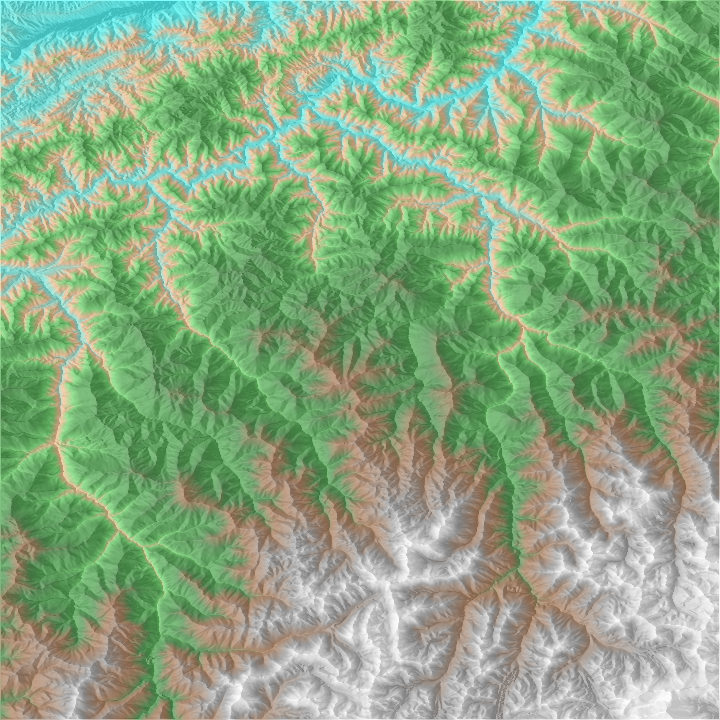

In [7]:
# Render the hillshade with a coloramp of the values applied on top
shaded = hillshade(da, azimuth=100, angle_altitude=50)
stack(shade(shaded, cmap=["white", "gray"]), shade(da, cmap=Elevation, alpha=128))